## Calcul de $e^{\pi}$
On va simuler par Monte-Carlo la valeur de $e^{\pi/4} \approx 2.19328$. Pour cela, On introduit la variable aléatoire S (le score) sur le jeu de fléchettes défini précédemment.

On a en effet $$\forall n \geqslant 0, \mathbb{P}(S \geqslant n)=\cfrac{(\pi/4)^{n}}{n!}$$

$$
\begin{align*}
\mathbb{E}(S)
  &=\sum_{n \geqslant 0} \mathbb{P}(S \geqslant n)
\\&=\sum_{n \geqslant 0} \cfrac{(\pi/4)^{n}}{n!}
\\&=e^{\pi/4}
\end{align*}
$$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

Text(0, 0.5, 'Erreur normalisée')

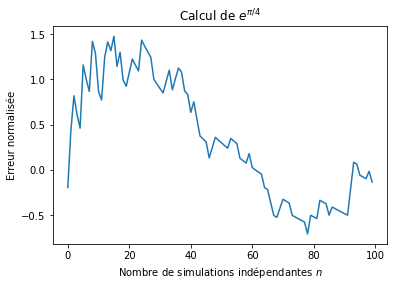

In [2]:
np.random.seed(0)

N_MAX = 20
N_SIM = 100
N_CREA = 500

lancers = np.random.rand(N_SIM, 2 * N_MAX)
np_range = np.arange(1, 1 + N_SIM)
plt.plot(np.sqrt(np_range) * (np.sum(np.cumsum(lancers ** 2, axis=1)[:, np.arange(1, 2 * N_MAX, 2)] <= 1, axis=1).cumsum() / np_range + 1 - np.exp(np.pi / 4)))
plt.title("Calcul de $e^{\pi / 4}$")
plt.xlabel("Nombre de simulations indépendantes $n$")
plt.ylabel("Erreur normalisée")

comparer EDP déterministe et simulation stochastique (sujet projet 2) ?

In [3]:
HEAVY_CREATURES = False

In [4]:
BOARDSIZE = 5 / 4
R_BULL = 5 / 128
R_HALFBULL = 13 / 128
S_BULL = 50
S_HALFBULL = S_BULL // 2
DOUBLES = 15 / 16, 1
TRIPLES = 9 / 16, 10 / 16
M_SIMPLE = 1
M_DOUBLE = 2
M_TRIPLE = 3
ZONE = np.array([6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10])
SCORE_MAX_ONE_SHOT = max(S_BULL, S_HALFBULL, max(ZONE) * max(M_SIMPLE, M_DOUBLE, M_TRIPLE))

CREATURE_SIZE = BOARDSIZE * (HEAVY_CREATURES + (not HEAVY_CREATURES) / 4)
CREATURE_CATEGORY = "grandes" * HEAVY_CREATURES + "petites" * (not HEAVY_CREATURES)

In [5]:
def score(r, t):
    return np.arange(SCORE_MAX_ONE_SHOT + 1)[
        S_BULL * (r <= R_BULL).astype(int) + \
        S_HALFBULL * ((R_BULL < r) & (r <= R_HALFBULL)).astype(int) + \
        (M_DOUBLE * ZONE[t]) * ((DOUBLES[0] < r) & (r <= DOUBLES[1])).astype(int) + \
        (M_TRIPLE * ZONE[t]) * ((TRIPLES[0] < r) & (r <= TRIPLES[1])).astype(int) + \
        (M_SIMPLE * ZONE[t]) * (((R_HALFBULL < r) & (r <= TRIPLES[0])) | ((TRIPLES[1] < r) & (r <= DOUBLES[0]))).astype(int)
    ]

In [6]:
def estimateur_flechettes(loi, **k):
    trueX, trueY = loi(np.tile(np.random.rand(N_SIM, N_MAX).reshape(N_SIM, N_MAX, 1), N_CREA), **k)
    bruitX, bruitY = 0.025 * np.random.randn(2, N_SIM, N_MAX, N_CREA) / k['v']
    lancersX, lancersY = trueX + bruitX, trueY + bruitY
    r = np.sqrt(lancersX ** 2 + lancersY ** 2)
    arctan = np.arctan(lancersY / lancersX)
    theta = 180 * ((0 < lancersX) * arctan + (lancersX < 0) * (np.pi + arctan)) / np.pi
    t = (((theta + 9) % 360) // 18).astype(int)  # Zone index
    flechettes = np.mean(np.sum(np.cumsum(lancersX ** 2 + lancersY ** 2, axis=1) <= 1, axis=1), axis=0)
    total = np.mean(np.sum(score(r, t) * (np.cumsum(lancersX ** 2 + lancersY ** 2, axis=1) <= 1), axis=1), axis=0)
#     total = np.mean(np.sum(score(r, t), axis=1), axis=0)
    return flechettes, total

In [7]:
t0 = lambda t, k: 3 * t - 1 / 2
f0 = lambda x, k: 0.5 + k['s'] * (x - k['a']) * x ** k['p'] * (x + k['a'])  # Cubic

t1 = lambda t, k: k['b'] * (3 * k['a'] * (t - 1) + k['a']) - k['a']
f1 = lambda x, k: (1 - k['a']) / k['a'] ** 2 * ((x + k['a']) / k['b'] - k['a']) ** 2 + (1 + 4 * (1 - k['a']) / k['a']) * ((x + k['a']) / k['b'] - k['a']) - 2 * k['a'] + 7 / 2

t2 = lambda t, k: k['a'] / k['da'] * (3 * t - 2) + k['a']
f2 = lambda x, k: - k['da'] * (x - k['a']) / k['a'] + 1 / 2

def piCreatureShape(t, **k):
    return np.array([
        k['mx'] + k['v'] * ((t <= 1 / 3) * (t0(t, k)) + ((1 / 3 < t) & (t <= 2 / 3)) * t1(t, k) + (2 / 3 < t) * t2(t, k)),
        k['my'] + k['v'] * ((t <= 1 / 3) * (f0(t0(t, k), k)) + ((1 / 3 < t) & (t <= 2 / 3)) * (f1(t1(t, k), k)) + (2 / 3 < t) * f2(t2(t, k), k))
    ])

In [8]:
def saveCreature(color, **k):
    t = np.linspace(0, 1, N_SIM)
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.xlim(np.array([-k['v']+k['mx'], k['v']+k['mx']]))
    plt.ylim(np.array([-k['v']+k['my'], k['v']+k['my']]))

    s = 2500 / k['v'] ** 1.5
    inA = 0.025 - 0.005 / k['v']
    shY = -0.03 + 0.045 / k['v']
    plt.scatter(k['mx']+k['v'] *(k['a']-inA), k['my'] + k['v'] *(0.57 + shY), s=1.5*s*k['v']**0.5, c=color)
    plt.scatter(k['mx']+k['v'] *(k['a']-inA), k['my']  + k['v'] *(0.565 + shY), s=s*k['v']**0.5, c='ivory')
    plt.scatter(k['mx']+k['v'] *(k['a']-inA)+0.01, k['my'] + k['v'] *(0.58 + shY), s=0.175*s*k['v']**0.5, c=color)
    plt.scatter(k['mx']+k['v'] *(k['a']-inA)-0.01, k['my']  + k['v'] *(0.605 + shY), s=0.05*s*k['v']**0.5, c='ivory')
    plt.scatter(k['mx']-k['v'] *(k['a']+inA), k['my'] + k['v'] *(0.57 + shY), s=1.65*s*k['v']**0.5, c=color)
    plt.scatter(k['mx']-k['v'] *(k['a']+inA), k['my']  + k['v'] *(0.565 + shY), s=1.1*s*k['v']**0.5, c='ivory')
    plt.scatter(k['mx']-k['v'] *(k['a']+inA)+0.01, k['my'] + k['v'] *(0.58 + shY), s=0.18*s*k['v']**0.5, c=color)
    plt.scatter(k['mx']-k['v'] *(k['a']+inA)-0.0075, k['my']  + k['v'] *(0.605 + shY), s=0.05*s*k['v']**0.5, c='ivory')

    calcul = piCreatureShape(np.linspace(0, 1, N_SIM), **k)
    plt.scatter(*calcul, s=1.5*s/2, c=color)
    plt.scatter(*calcul, s=s/3, c='ivory')
    t = np.linspace(0.723 - 0.005 * k['v'], 0.764 + 0.005 * k['v'], 20)
    plt.plot(k['mx'] + k['v'] *(0.5 * np.cos(2*np.pi*t)), k['my'] + k['v'] *(0.98+ 0.5 * np.sin(2*np.pi*t)), c=color, linewidth=7.5 / k['v'] **0.5)
    plt.savefig("images/piCreature.png", transparent=True, bbox_inches='tight')
    plt.close()

In [9]:
SPACING_MIN, SPACING_MAX = 0.1, 0.3
LEFT_LEG_MIN, LEFT_LEG_MAX = 0.5, 1.5
RIGHT_LEG_MIN, RIGHT_LEG_MAX = 1, 1.5
P_MIN, P_MAX = 3, 4
SQUARE_SIZE = 0.4 + 0.3 * (not HEAVY_CREATURES)

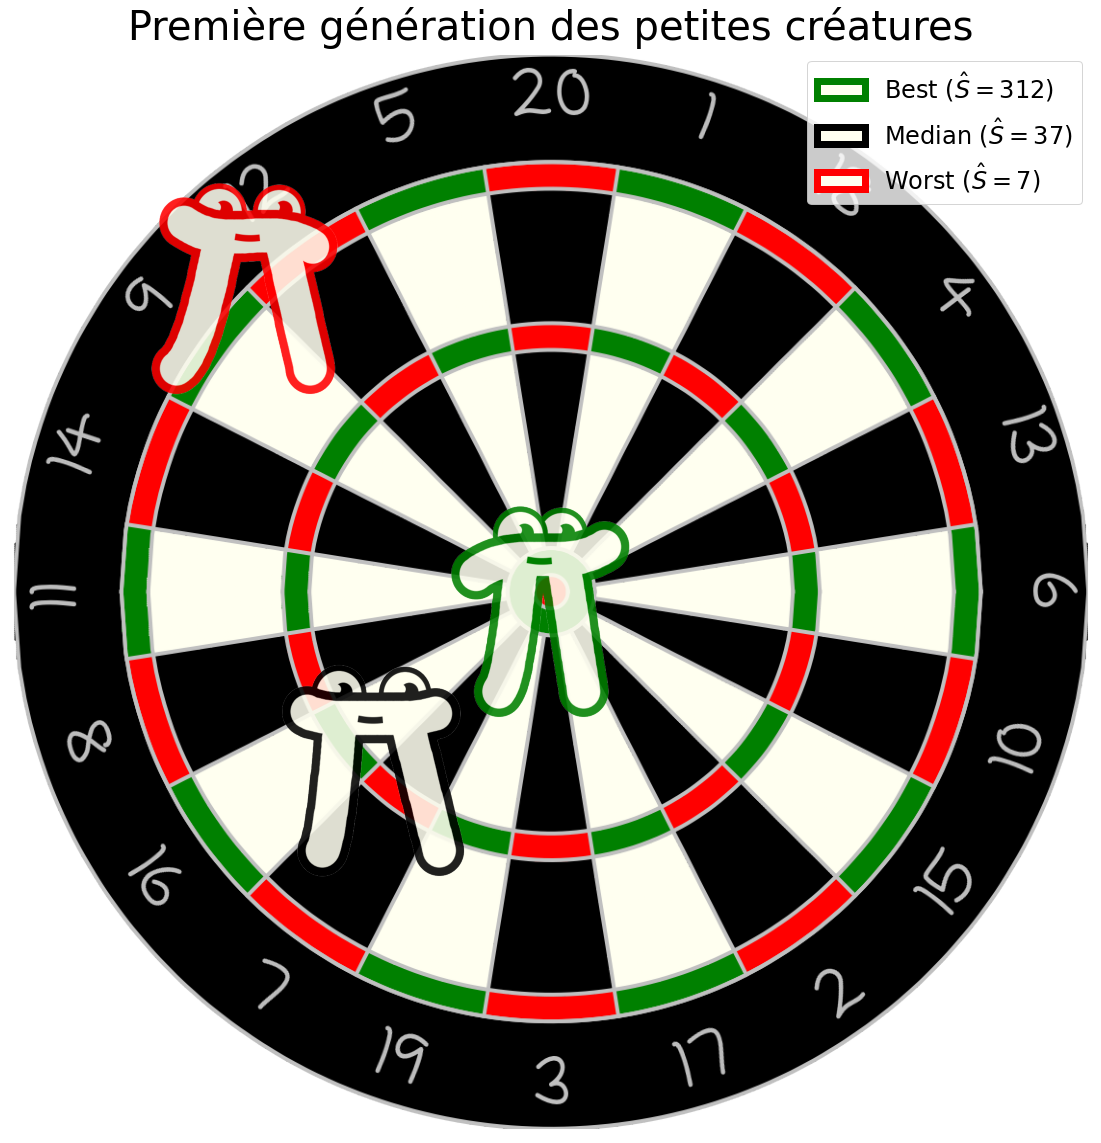

In [10]:
a = SPACING_MIN + (SPACING_MAX - SPACING_MIN) * np.random.rand(N_CREA)  # Can change
mx, my = SQUARE_SIZE * (2 * np.random.rand(2, N_CREA) - 1)  # Can change


b = LEFT_LEG_MIN + (LEFT_LEG_MAX - LEFT_LEG_MIN) * np.random.rand(N_CREA)  # Fixed at start
s = 2 * np.random.randint(0, 2, size=N_CREA) - 1  # Fixed at start
da = RIGHT_LEG_MIN + (RIGHT_LEG_MIN - RIGHT_LEG_MIN) * np.random.rand(N_CREA)  # Fixed at start
p = np.random.randint(P_MIN - 2, P_MAX-1, size=N_CREA)  # Fixed at start
v= CREATURE_SIZE * np.ones(N_CREA)  # Fixed at start


f, t = estimateur_flechettes(piCreatureShape, a=a, mx=mx, my=my, da=da, p=p, b=b, s=s,v=v)

plt.figure(figsize=(20,20))
plt.title(f"Première génération des {CREATURE_CATEGORY} créatures", fontsize=40)
plt.axis('off')
cfile=plt.imread("images/cibles/1.00.png")
plt.imshow(cfile, extent=[-BOARDSIZE, BOARDSIZE, -BOARDSIZE, BOARDSIZE])
piC=plt.imread("images/piCreatures/0.15.png")
am = np.argmin(t)
aA = np.argsort(t)[len(t)//2]  # median
aT = np.argmax(t)
for aM, color in zip((am, aA, aT), ("red", "black", "green")):
    saveCreature(color, a=a[aM], mx=mx[aM], my=my[aM], da=da[aM], p=p[aM], b=b[aM], s=s[aM], v=v[aM])
    piC = plt.imread("images/piCreature.png")
    plt.imshow(piC, extent=[-v[aM]+mx[aM], v[aM]+mx[aM], -v[aM]+my[aM], v[aM]+my[aM]],alpha=0.875)
plt.xlim([-BOARDSIZE, BOARDSIZE])
plt.ylim([-BOARDSIZE, BOARDSIZE])

legend_elements = [
    Patch(facecolor='ivory', edgecolor='g', linewidth=7,label=f'Best ($\hat{{S}} = {int(t[aT])}$)'),
    Patch(facecolor='ivory', edgecolor='k', linewidth=7,label=f'Median ($\hat{{S}} = {int(t[aA])}$)'),
    Patch(facecolor='ivory', edgecolor='r', linewidth=7,label=f'Worst ($\hat{{S}} = {int(t[am])}$)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=24)
plt.show()

(array([250., 142.,  41.,  18.,   8.,  12.,   6.,   6.,  11.,   6.]),
 array([  7.29 ,  37.773,  68.256,  98.739, 129.222, 159.705, 190.188,
        220.671, 251.154, 281.637, 312.12 ]),
 <BarContainer object of 10 artists>)

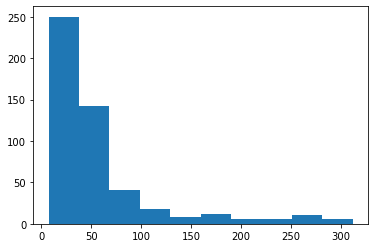

In [11]:
plt.hist(t)